In [1]:
import os
import logging
from transformers import logging as transformers_logging
import tensorflow as tf
from mongo_db_client import MongoDbClient
from embedding_dataset import EmbeddingDataset
import numpy as np
from embedding_generator import EmbeddingGenerator
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterator, List
from embedding_generator import EmbeddingPairBatch, EmbeddingPair
import random
import pandas as pd

random.seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
transformers_logging.set_verbosity_error()

/Users/beto/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
csv = pd.read_csv('../analysis/raw_data.csv')

In [6]:
csv.head(5)

,Unnamed: 0,sample,code,positive_comment,negative_comment
0,0,0,"['def', 'addidsuffix', '(', 'self', ',', 'idsu...","['Appends', 'a', 'suffix', 'to', 'this', 'elem...","['Associate', 'a', 'document', 'with', 'this',..."
1,1,1,"['def', 'findArgs', '(', 'args', ',', 'prefixe...","['Extracts', 'the', 'list', 'of', 'arguments',...","['Determines', 'if', 'the', 'Engine', 'is', 'a..."
2,2,2,"['def', 'show_clock_output_clock_time_timezone...","['Auto', 'Generated', 'Code']","['Detects', 'the', 'descriptor', 'file', 'for'..."
3,3,3,"['def', 'setparents', '(', 'self', ')', ':', '...","['Correct', 'all', 'parent', 'relations', 'for...","['Retrieves', 'the', 'compiler', 'flags', 'for..."
4,4,4,"['def', 'stripArgs', '(', 'args', ',', 'blackl...","['Removes', 'any', 'arguments', 'in', 'the', '...","['Removes', 'any', 'arguments', 'in', 'the', '..."


In [4]:
# TODO: Move this to EmbeddingGenerator class
def unwrap_embedding_batch(embedding_batch: EmbeddingPairBatch) -> Iterator[EmbeddingPair]:
  for id, code_emb, comment_emb in zip(embedding_batch['pairs_ids'], embedding_batch['code_embeddings'], embedding_batch['comment_embeddings']):
    yield {
      'id': id,
      'code_embedding': code_emb,
      'comment_embedding': comment_emb,
    }

In [5]:
embeddings_batch = list(embedding_generator.from_pairs_raw(pairs))

In [12]:
embeddings: List[EmbeddingPair] = []
for emb_batch in embeddings_batch:
  embeddings += list(unwrap_embedding_batch(emb_batch))
len(embeddings)

100

In [13]:
neg_embeddings = embeddings.copy()
random.shuffle(neg_embeddings)
len(neg_embeddings)

100

In [14]:
equal_pairs_count = 0
for id, neg_id in zip(embeddings, neg_embeddings):
  if id == neg_id:
    equal_pairs_count += 1
print(f'{equal_pairs_count} pairs are equal')

1 pairs are equal


In [9]:
embeddings[0]['code_embedding'].shape, embeddings[0]['comment_embedding'].shape

((512, 768), (512, 1024))

# Generate embeddings_raw dataset
If it works, move to main.py

In [10]:
# train_pairs = list(MongoDbClient().get_pairs_collection().find({ "partition": "train", "language": "python" }).limit(20000))
# valid_pairs = list(MongoDbClient().get_pairs_collection().find({ "partition": "valid", "language": "python" }).limit(4000))
# test_pairs = list(MongoDbClient().get_pairs_collection().find({ "partition": "test", "language": "python" }).limit(4000))  

In [11]:
# all_pairs = train_pairs + valid_pairs + test_pairs
# with EmbeddingDataset(dataset_dir='../datasets/embeddings/', dataset_name='embeddings_raw', mode='w') as embedding_ds:
#   for embedding_batch in embedding_generator.from_pairs_raw(all_pairs):
#     embedding_ds.save(embedding_batch)

In [1]:
list(MongoDbClient().get_pairs_collection().find({ "partition": "train", "language": "python" }).limit(20000))[0]['id']

NameError: name 'train_pairs' is not defined

In [16]:
def plot_pair(positive: EmbeddingPair, negative: EmbeddingPair, title: str):
  fig, axes = plt.subplots(2, 2, constrained_layout=True)
  code_graph, comment_graph, neg_comment_graph, diff_graph = axes[0][0], axes[0][1], axes[1][0], axes[1][1]
  
  comment_diff = np.absolute(positive['comment_embedding'] - negative['comment_embedding'])

  code_graph.imshow(positive['code_embedding'])
  code_graph.set_title('Code')

  comment_graph.imshow(positive['comment_embedding'])
  comment_graph.set_title('Comment')

  neg_comment_graph.imshow(negative['comment_embedding'])
  neg_comment_graph.set_title('Negative comment')

  diff_graph.imshow(comment_diff)
  diff_graph.set_title('Comment Diff')

  fig.suptitle(title)
  
  fig.show()
  # fig_path = os.path.join(self.plots_dir, title)
  # fig.savefig(fig_path)
  # plt.close(fig)


In [48]:
from typing import cast
from scipy.spatial import distance

def cos_similarity(a, b) -> float:
  a = tf.reshape(a, (-1))
  b = tf.reshape(b, (-1))

  return cast(float, distance.cosine(a, b)) 

def euclidean_distance(a, b) -> float:
  a = tf.reshape(a, (-1))
  b = tf.reshape(b, (-1))

  return distance.euclidean(a, b)


In [57]:
a = np.array([1, 2, 3])
b1 = np.cross(a, [1, 0, 0])
b2 = np.cross(a, b1)

distance.cosine(a, b1), distance.euclidean(a, b1)

(1.0, 5.196152422706632)

In [64]:
def plot_similarities(similarities: np.ndarray | list, title: str):
  plt.plot(similarities)
  plt.title(title)
  plt.xlabel('num. of samples')
  plt.ylabel('distance')
  plt.show()

In [61]:
import itertools

def analyze_dataset(dataset_name: str, samples_count: int = 100):
  with EmbeddingDataset(dataset_name, '../datasets/embeddings/') as ds:
    positives = list(itertools.islice(ds.list(), samples_count))
  negatives = positives.copy()
  random.shuffle(negatives)

  equal_pairs_count = 0
  for pos, neg in zip(positives, negatives):
    if pos['id'] == neg['id']:
      equal_pairs_count += 1
  print(f"{equal_pairs_count} equal pairs for '{dataset_name}' embedding dataset")

  cos_sims = [cos_similarity(emb['comment_embedding'], neg_emb['comment_embedding']) for emb, neg_emb in zip(positives, negatives)]
  cos_sims.sort()

  euclidean_distances = [euclidean_distance(emb['comment_embedding'], neg_emb['comment_embedding']) for emb, neg_emb in zip(positives, negatives)]
  euclidean_distances.sort()

  plot_similarities(euclidean_distances, 'euclidean distance')
  plot_similarities(cos_sims, 'cosine distance')

def analyze_dataset_equal(dataset_name: str, samples_count: int = 100):
  with EmbeddingDataset(dataset_name, '../datasets/embeddings/') as ds:
    positives = list(itertools.islice(ds.list(), samples_count))
  negatives = positives.copy()
  random.shuffle(negatives)

  cos_sims = [cos_similarity(emb['comment_embedding'], emb['comment_embedding']) for emb in positives]
  cos_sims.sort()

  euclidean_distances = [euclidean_distance(emb['comment_embedding'], emb['comment_embedding']) for emb in positives]
  euclidean_distances.sort()

  plot_similarities(euclidean_distances, 'euclidean distance*')
  plot_similarities(cos_sims, 'cosine distance*')

In [67]:
with EmbeddingDataset('embeddings_raw', '../datasets/embeddings/') as ds:
  first = next(ds.list())
  print(first['code_embedding'].shape, first['comment_embedding'].shape)

(512, 768) (512, 1024)


1 equal pairs for 'embeddings' embedding dataset


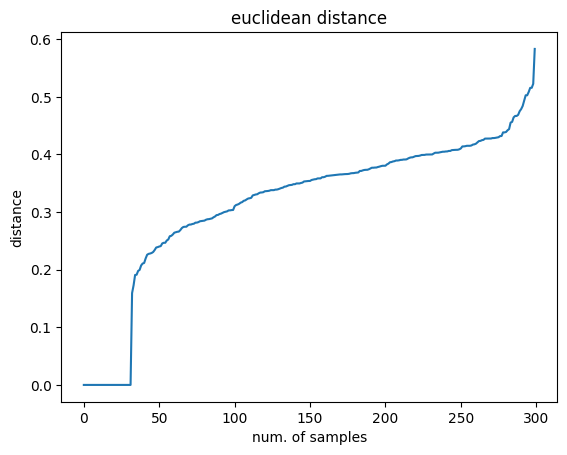

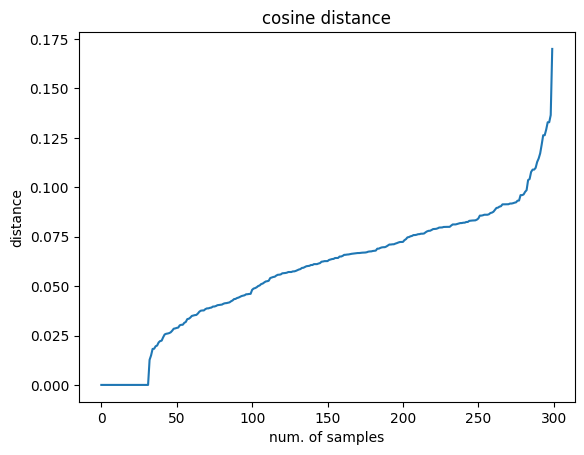

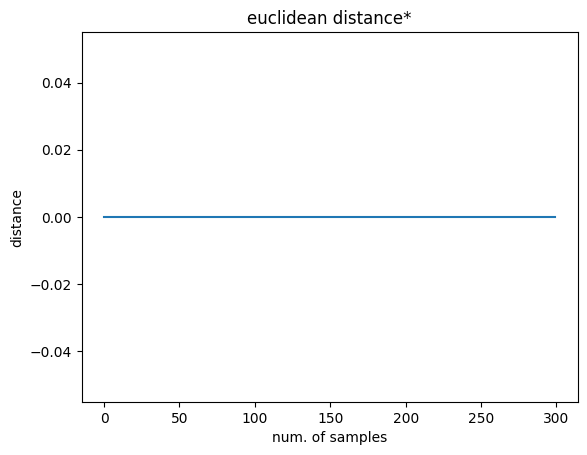

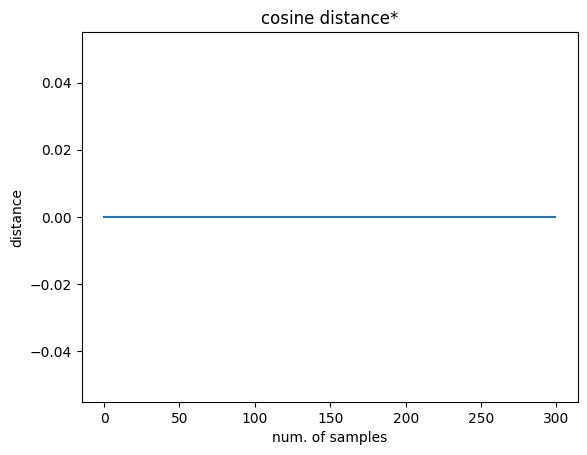

(None, None)

In [65]:
analyze_dataset('embeddings', 300), analyze_dataset_equal('embeddings', 300)

0 equal pairs for 'embeddings_raw' embedding dataset


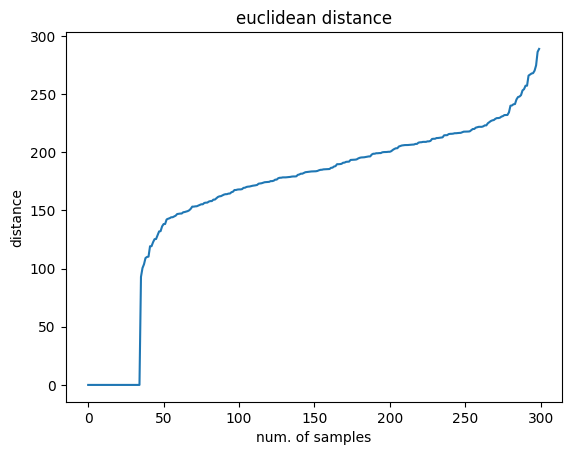

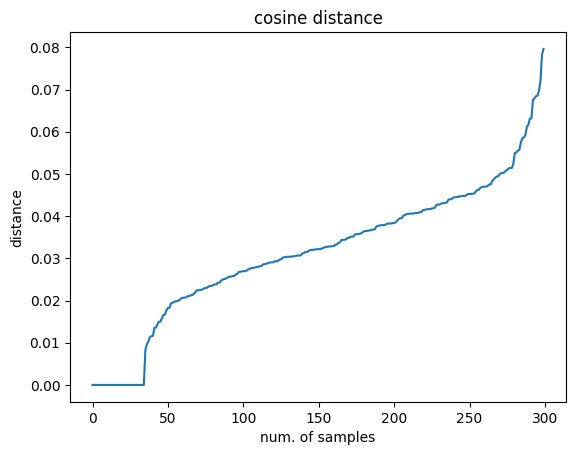

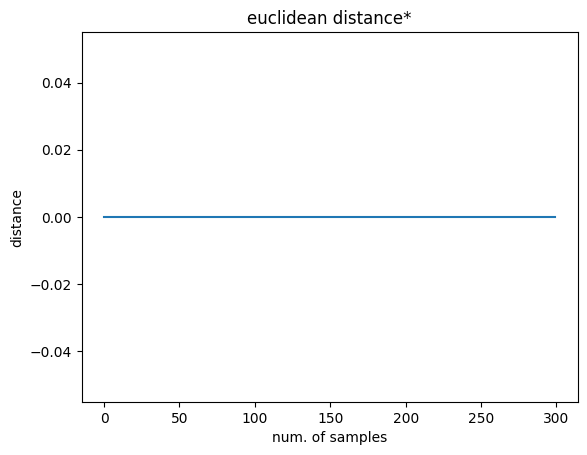

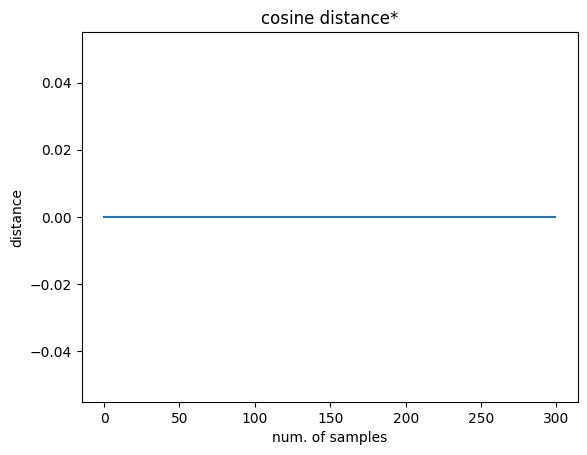

(None, None)

In [66]:
analyze_dataset('embeddings_raw', 300), analyze_dataset_equal('embeddings_raw', 300)